In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
DATA_PATH = '../data/'
POSTPROCESSING = 'postprocessing/'
RAW = 'raw/'

In [35]:
content = pd.read_csv(f"{DATA_PATH}{RAW}content.csv", index_col='content_uid')
content.head()

,name,type,serial_id,genres,duration_seconds
content_uid,,,,,
9882,"""Шоу ""Студия ""Союз""",serial_with_season,NaN,"Игровое шоу,Музыка",NaN
13701,"""Шоу ""Студия ""Союз""",episode,9882.0,NaN,2823.0
12274,"""Шоу ""Студия ""Союз""",episode,9882.0,NaN,2694.0
13579,"""Шоу ""Студия ""Союз""",episode,9882.0,NaN,2739.0
18055,"""Шоу ""Студия ""Союз""",episode,9882.0,NaN,2887.0


In [36]:
history = pd.read_csv(f'{DATA_PATH}{RAW}watch_history.csv')
history.head()

,user_uid,content_uid,second
0,1,26719,400
1,1,11882,627
2,1,26174,5693
3,4,28436,828
4,4,3836,64


Распределение контента по типам

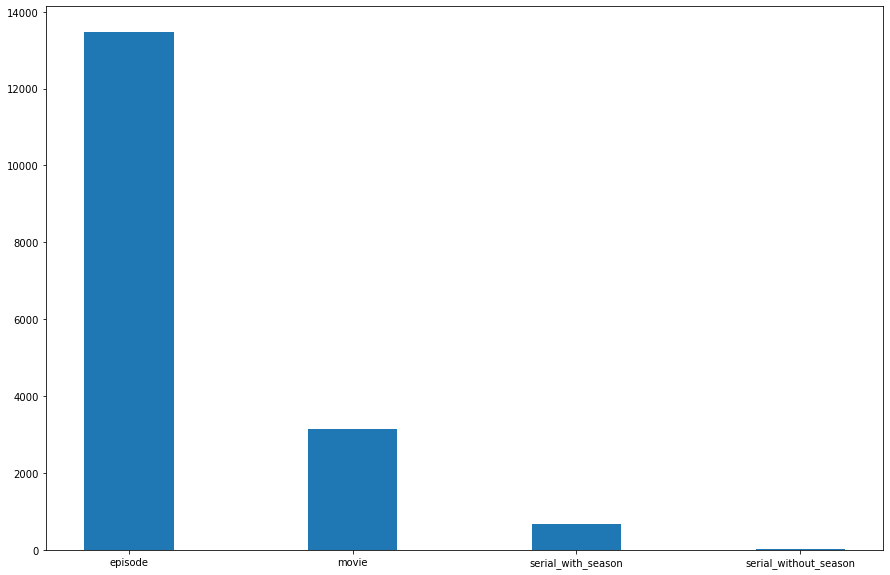

In [37]:
info = np.unique(content['type'], return_counts=True)
plt.figure(figsize=(15, 10))
plt.bar(x=np.arange(1, 8, 2), height=info[1])
plt.xticks(np.arange(1, 8, 2), info[0])
plt.savefig(f'{DATA_PATH}plots/type_bar.png')
plt.show()

Пропуски длительности контента по типу

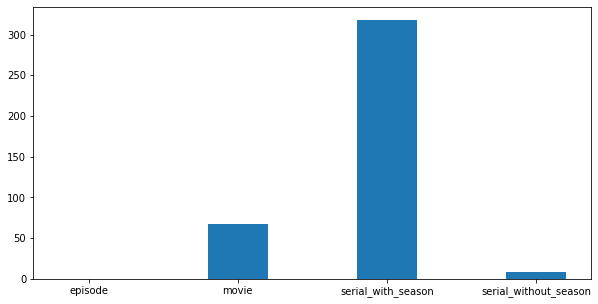

In [38]:
info = content.groupby(by=['type']).agg(
    count_nan = pd.NamedAgg(column='duration_seconds', aggfunc=lambda x: x.isna().sum())
)

plt.figure(figsize=(10, 5))
plt.bar(x=np.arange(1, 8, 2), height=info.values.reshape(1, -1)[0])
plt.xticks(np.arange(1, 8, 2), list(info.index))
plt.savefig(f'{DATA_PATH}plots/missed_types.png')
plt.show()

In [39]:
miss_duration = content[(content['type'] == 'movie') &
                        (content['duration_seconds'].isna())].index.to_list()
print(f'Всего пропущено значений длительности фильмов - {len(miss_duration)}')

Всего пропущено значений длительности фильмов - 68


Заполним пропуски длительности фильмов, собранной информацией

In [40]:
collect_data_path = '../data/raw/missed_movies.csv'
collect_data = pd.read_csv(collect_data_path, index_col=1)

* Не всю информацию удалось собрать

In [41]:
delete_list = collect_data[collect_data['duration_seconds'].isna()].index.to_list()
delete_list

[25226]

In [42]:
content.loc[collect_data.index, 'duration_seconds'] = collect_data['duration_seconds'] * 60

In [43]:
history = history.drop(history[history['content_uid'].isin(delete_list)].index)
content = content.drop(content[content.index.isin(delete_list)].index)

Объединяем эпизоды сериала в единый контент

In [44]:
seasons_serials_duration = content[content.type.isin(['episode'])][['serial_id', 'duration_seconds']].groupby(by='serial_id').sum()
seasons_serials_duration

,duration_seconds
serial_id,
250.0,2605.0
551.0,34311.0
691.0,10652.0
841.0,42302.0
992.0,44345.0
...,...
30165.0,80412.0
30266.0,61665.0
30407.0,56563.0


In [45]:
content.loc[seasons_serials_duration.index, 'duration_seconds'] = seasons_serials_duration

Удаляем контент, без эпизодов => без просморов

In [46]:
id = content[content.duration_seconds.isna()].index
history[history.content_uid.isin(id)]

,user_uid,content_uid,second


In [47]:
content.drop(id, inplace=True)

Обновляем историю просмотров

In [48]:
history[history.content_uid.isin(
    content[content.type == 'serial_with_season'].index
)]


,user_uid,content_uid,second


In [49]:
history['content_uid'] = history['content_uid'].apply(lambda x: content.loc[x, 'serial_id'] if content.loc[x, 'type'] == 'episode' else x)
history.head()

,user_uid,content_uid,second
0,1,26719.0,400
1,1,11882.0,627
2,1,26174.0,5693
3,4,28436.0,828
4,4,3836.0,64


In [50]:

history = history.groupby(by=['user_uid', 'content_uid']).sum().reset_index()

Тк мы скомпоновали эпизоды по сериалам, сами эпизоды нам не нужны

In [51]:
content.drop(content[content.type == 'episode'].index, inplace=True)

Пропуски значений после фильтрации

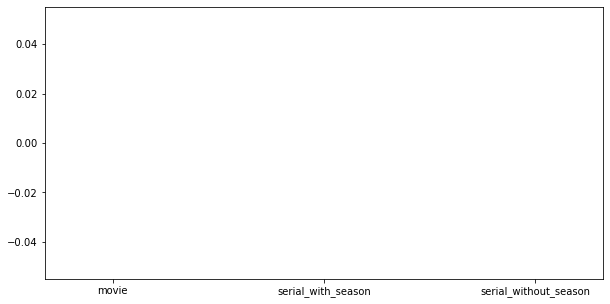

In [56]:
info = content.groupby(by=['type']).agg(
    count_nan = pd.NamedAgg(column='duration_seconds', aggfunc=lambda x: x.isna().sum())
)

plt.figure(figsize=(10, 5))
plt.bar(x=np.arange(1, 6, 2), height=info.values.reshape(1, -1)[0])
plt.xticks(np.arange(1, 6, 2), list(info.index))
plt.savefig(f'{DATA_PATH}plots/post_missed_types.png')
plt.show()

In [55]:
content.to_csv(f'{DATA_PATH}{POSTPROCESSING}content.csv')
history.to_csv(f'{DATA_PATH}{POSTPROCESSING}watch_history.csv')
